# Markov Chains Rock

A markov chain is a blah blah blah


Markov matrices, also known as [stochastic matrices](https://en.wikipedia.org/wiki/Stochastic_matrix)

It can be described by a matrix



x = M x 

In his 1948 paper, [*A mathematical theory of communication.*](https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf), Claude Shannon identified a method of genering text using Markov Chains - specifically using n-grams.



Here's one I made earlier. In fact, let's test it out - we shall try to generate [Moby Dick](https://www.gutenberg.org/ebooks/15) as from project Gutenberg.

First I clean it up to remove copyright markings, and then train the model.


In [70]:
import collections, random, sys, textwrap, urllib

N = 2 # n-gram size

def circ(words, word):
    """pop first element and push `word` onto the end"""
    words.pop(0)
    words.append(word)

## Training Data
Get a data source. In this case, I will use Moby Dick

In [71]:
target_url = "https://courses.cs.washington.edu/courses/cse390c/22sp/lectures/moby.txt"
data = urllib.request.urlopen(target_url)

## Training
Training for the Markov chain is fundamentally the following;
Build a table of possible grams, indexed by n-grams

In [72]:
ws = ['' for _ in range(N)]
possibles = collections.defaultdict(list)
for i, line in enumerate(data):
    for word in line.split():
        possibles[tuple(ws)].append(word)
        circ(ws, word)

# Avoid empty possibles lists at end of input
possibles[tuple(ws)].append('')
circ(ws,'')
possibles[tuple(ws)].append('')

In [73]:
num_to_generate = 800

# Generate randomized output (start with a random capitalized prefix)
ws = list(random.choice([k for k in possibles if k[0][:1].isupper()]))
output = list(ws)
for _ in range(int(num_to_generate)):
    word = random.choice(possibles[tuple(ws)])
    output.append(word)
    circ(ws, word)

# Print output wrapped to 70 columns
output = [o.decode("utf-8") for o in output]
print(textwrap.fill(' '.join(output)))

The question is, what and where is the widow's last mite but a
vertical, or up-and-down tail. Whereas, among spouting fish with a
thought which somewhat explained all the added power of speed to rid
himself of the Equator awhile, they start for the present day; though
doubtless the original usage was introduced by an appointed hand, and
leaping from their stationary fright. First, the whales had been four
voyages in the former has an ill effect, giving its owner something
analogous to the main-mast and the best authorities, he has never yet
saw him standing in a hen-house. A few years ago an old established
family in the land, the Van Rensselaers, or Randolphs, or
Hardicanutes. And more than if he had already done so, and never will.
But if such an eatable look that the digestive organs of the alleged
uncleanliness of our going together among the boats; and one of our
Lake Erie, Don; but- I crave your courtesy- may be, you shall soon
hear further of all Polynesia confess the same opini

Analysis

What about images?


There is a way to generate images with a markov-chain like system


[Texture Synthesis by Non-parametric Sampling (Efros and Leung, 1999)](https://people.eecs.berkeley.edu/~efros/research/EfrosLeung.html) is an interesting solution to the problem of image generation.

the paper is [available here](https://people.eecs.berkeley.edu/~efros/research/NPS/efros-iccv99.pdf)

In [76]:
import numpy as np
from scipy.ndimage import gaussian_filter, binary_dilation
from scipy.spatial.distance import cdist
import random

# Constants
ErrThreshold = 0.1
MaxErrThreshold = 0.3
WindowSize = 5  # Example window size, can be changed as needed
Sigma = WindowSize / 6.4

def GrowImage(SampleImage, Image, WindowSize):
    MaxErrThreshold_local = MaxErrThreshold
    while not np.all(Image != -1):  # Assuming unfilled pixels are marked with -1
        progress = 0
        PixelList = GetUnfilledNeighbors(Image)
        for Pixel in PixelList:
            Template = GetNeighborhoodWindow(Pixel, Image, WindowSize)
            BestMatches = FindMatches(Template, SampleImage, WindowSize)
            if BestMatches:
                BestMatch = RandomPick(BestMatches)
                if BestMatch['error'] < MaxErrThreshold_local:
                    Image[Pixel[0], Pixel[1]] = BestMatch['value']
                    progress = 1
        if progress == 0:
            MaxErrThreshold_local *= 1.1
    return Image

def GetUnfilledNeighbors(Image):
    # Assuming unfilled pixels are marked with -1 and filled with other values
    filled_mask = Image != -1
    dilated_mask = binary_dilation(filled_mask)
    border_mask = dilated_mask & ~filled_mask
    unfilled_neighbors = np.argwhere(border_mask)
    # Optionally, sort by the number of filled neighbors (not implemented here)
    np.random.shuffle(unfilled_neighbors)  # Random permutation
    return unfilled_neighbors


def GetNeighborhoodWindow(Pixel, Image, WindowSize):
    # Pad the image to handle edges
    pad_width = WindowSize // 2
    padded_image = np.pad(Image, pad_width, mode='constant', constant_values=-1)
    # Adjust the pixel location for the padding
    Pixel_padded = (Pixel[0] + pad_width, Pixel[1] + pad_width)
    # Extract the window
    window = padded_image[Pixel_padded[0]-pad_width:Pixel_padded[0]+pad_width+1, 
                          Pixel_padded[1]-pad_width:Pixel_padded[1]+pad_width+1]
    return window


def RandomPick(BestMatches):
    return random.choice(BestMatches)

def FindMatches(Template, SampleImage, WindowSize):
    # Create the ValidMask
    ValidMask = (Template != -1).astype(np.float32)
    # Gaussian mask
    GaussMask = Gaussian2D(WindowSize, Sigma)
    TotWeight = np.sum(GaussMask * ValidMask)
    
    # Initialize SSD to a high value
    SSD = np.full(SampleImage.shape, np.inf)
    
    # Iterate over SampleImage
    for i in range(SampleImage.shape[0] - WindowSize + 1):
        for j in range(SampleImage.shape[1] - WindowSize + 1):
            # Extract window
            window = SampleImage[i:i+WindowSize, j:j+WindowSize]
            # Compute SSD
            dist = (window - Template) ** 2
            SSD[i,j] = np.sum(dist * ValidMask * GaussMask) / TotWeight
    
    # Find pixels with SSD less than the threshold
    min_SSD = np.min(SSD[np.isfinite(SSD)])
    threshold = min_SSD * (1 + ErrThreshold)
    matches = np.argwhere(SSD <= threshold)
    
    # Construct a list of dictionaries for each match
    BestMatches = [{'error': SSD[match[0], match[1]], 'value': SampleImage[match[0], match[1]]} for match in matches]
    return BestMatches

def Gaussian2D(WindowSize, Sigma):
    ax = np.arange(-WindowSize // 2 + 1., WindowSize // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * Sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

analysis

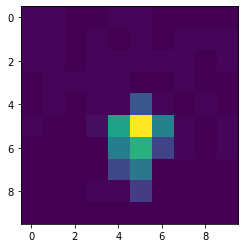

In [82]:
# Example usage of GrowImage
np.random.seed(42)  # For reproducibility

# Generate a sample image (e.g., a simple gradient)
SampleImage = np.linspace(0, 1, 100).reshape((10, 10))

# Generate an initial image with a single seed value in the center
Image = -np.ones_like(SampleImage)
Image[5, 5] = SampleImage[5, 5]

# Grow the image - this is the fun bit!
y = list(SampleImage)
GrownImage = GrowImage(SampleImage, Image, WindowSize)

plt.imshow(GrownImage)